# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                              
Sample_055  A0A0A0MTI5;B8ZWD1;P07108;P07108-2;P07108-3;P07108-4;P07108-5   18.412
Sample_066  P78539;P78539-2;P78539-3;P78539-5                              15.281
Sample_120  E9PG71;P54764                                                  18.649
Sample_050  P29622                                                         20.452
Sample_160  A0A087X0D5;P09668                                              15.182
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_038  Q9NZU1           10.675
Sample_017  K7ENA4;K7ESL8    14.699
Sample_005  P01817           14.328
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.677
            A0A075B6Q5                 12.527
            A0A075B6R2                 14.276
            A0A075B6S5                 11.341
            A0A087WSY4                 13.280
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.235
            Q9UI40;Q9UI40-2            12.091
            Q9UIW2                     12.500
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.169
            Q9UP79                     12.852
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.885,15.050,16.842,19.863,16.271,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.658,19.067,...,15.528,15.576,14.001,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.111,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.015,17.705,17.039,15.663,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.128,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.422,15.345,17.084,18.708,14.249,19.433,11.283,10.903
Sample_207,15.739,16.877,15.469,16.898,13.566,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.420,13.047,12.193,12.780,12.387,13.012,12.431,13.160,11.401,14.351
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.122,19.067,16.127,...,13.291,12.383,13.209,12.199,12.892,12.874,12.043,12.401,13.023,11.798
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.643,13.215,12.807,12.490,12.894,13.322,11.967,12.614,13.435,12.463
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.712,13.277,13.621,12.923,12.967,12.788,12.588,14.101,12.313,12.206
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.804,12.947,12.990,12.550,12.931,13.146,14.332,12.627,12.619,13.654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.729,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 312.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.93it/s]

100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.68it/s]

100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.53it/s]

100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.43it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.65it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.31it/s]

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

100%|██████████| 5/5 [00:01<00:00,  4.33it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.09it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.27it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.25it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.08it/s]

100%|██████████| 6/6 [00:01<00:00,  4.03it/s]

100%|██████████| 6/6 [00:01<00:00,  4.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.15it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.44it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.82it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.85it/s]

100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.28it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.91it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.36it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.83it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.71it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.65it/s]

100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.04it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.79it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.09it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.57it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.52it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.41it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.42it/s]

100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.69it/s]

 30%|███       | 3/10 [00:00<00:01,  4.26it/s]

 40%|████      | 4/10 [00:00<00:01,  3.93it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.72it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.55it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.49it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.47it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.50it/s]

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.00it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.88it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.58it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.19it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.53it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.19it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.04it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.84it/s]

100%|██████████| 11/11 [00:02<00:00,  3.62it/s]

100%|██████████| 11/11 [00:02<00:00,  4.34it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.79it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.66it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.69it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.30it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.93it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.86it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.81it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.80it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.62it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.60it/s]

100%|██████████| 12/12 [00:02<00:00,  3.73it/s]

100%|██████████| 12/12 [00:02<00:00,  4.03it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.50it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.45it/s]

 31%|███       | 4/13 [00:00<00:02,  4.10it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.19it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.93it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.81it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.70it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.79it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.89it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.12it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.14it/s]

100%|██████████| 13/13 [00:03<00:00,  3.96it/s]

100%|██████████| 13/13 [00:03<00:00,  4.03it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.87it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.40it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.99it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.52it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.39it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.45it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.57it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.23it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.74it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.55it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.44it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.58it/s]

100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.00it/s]

 20%|██        | 3/15 [00:00<00:03,  3.91it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.23it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.06it/s]

 40%|████      | 6/15 [00:01<00:03,  2.94it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.94it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.06it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.13it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.11it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.09it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.33it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.41it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.46it/s]

100%|██████████| 15/15 [00:04<00:00,  3.56it/s]

100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.037 0.006          0.547 0.454       0.069   
2             0.003 0.000      0.037 0.003          0.767 0.098       0.711   
3             0.003 0.000      0.036 0.001          0.826 0.089       0.740   
4             0.003 0.000      0.035 0.005          0.783 0.095       0.780   
5             0.004 0.000      0.037 0.003          0.778 0.095       0.756   
6             0.004 0.000      0.038 0.009          0.821 0.075       0.800   
7             0.004 0.000      0.036 0.001          0.823 0.072       0.781   
8             0.004 0.000      0.036 0.002          0.832 0.076       0.807   
9             0.004 0.000      0.038 0.006          0.824 0.078       0.814   
10            0.004 0.001      0.036 0.006          0.822 0.080       0.816   
11            0.004 0.001      0.035 0.003          0.831 0.087       0.830   
12            0.003 0.001      0.029 0.006          0.823 0.087       0.822   
13            0.007 0.006      0.071 0.022          0.822 0.087       0.814   
14            0.004 0.002      0.041 0.010          0.827 0.089       0.816   
15            0.007 0.007      0.056 0.030          0.816 0.089       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.079   0.118 0.123                  0.529 0.037        0.847   
2          0.105   0.732 0.078                  0.774 0.062        0.865   
3          0.100   0.775 0.072                  0.811 0.056        0.870   
4          0.116   0.776 0.081                  0.809 0.067        0.884   
5          0.124   0.760 0.086                  0.797 0.069        0.885   
6          0.087   0.807 0.063                  0.835 0.052        0.909   
7          0.090   0.798 0.063                  0.828 0.052        0.911   
8          0.096   0.816 0.069                  0.843 0.057        0.922   
9          0.096   0.816 0.070                  0.843 0.058        0.923   
10         0.088   0.816 0.067                  0.843 0.057        0.922   
11         0.091   0.827 0.070                  0.852 0.059        0.926   
12         0.099   0.819 0.075                  0.845 0.064        0.924   
13         0.099   0.814 0.074                  0.841 0.063        0.922   
14         0.100   0.818 0.076                  0.844 0.064        0.923   
15         0.096   0.809 0.075                  0.837 0.063        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.821 0.087        210.000 0.000  
2          0.061                  0.838 0.082        210.000 0.000  
3          0.062                  0.843 0.082        210.000 0.000  
4          0.052                  0.859 0.066        210.000 0.000  
5          0.052                  0.860 0.064        210.000 0.000  
6          0.045                  0.895 0.052        210.000 0.000  
7          0.046                  0.897 0.052        210.000 0.000  
8          0.042                  0.909 0.048        210.000 0.000  
9          0.042                  0.911 0.045        210.000 0.000  
10         0.041                  0.911 0.046        210.000 0.000  
11         0.042                  0.915 0.048        210.000 0.000  
12         0.044                  0.912 0.051        210.000 0.000  
13         0.044                  0.910 0.050        210.000 0.000  
14         0.044                  0.911 0.051        210.000 0.000  
15         0.045                  0.910 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 512.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.20it/s]

100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.31it/s]

100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.75it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.47it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.90it/s]

100%|██████████| 5/5 [00:01<00:00,  2.81it/s]

100%|██████████| 5/5 [00:01<00:00,  3.05it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.39it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.79it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.02it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.32it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.05it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.61it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.47it/s]

100%|██████████| 7/7 [00:02<00:00,  2.28it/s]

100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.63it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.34it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.46it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.39it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.33it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.47it/s]

100%|██████████| 8/8 [00:03<00:00,  2.51it/s]

100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.16it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.02it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.73it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.21it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.22it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.50it/s]

100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.18it/s]

 30%|███       | 3/10 [00:00<00:02,  3.48it/s]

 40%|████      | 4/10 [00:01<00:01,  3.07it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.41it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.33it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.35it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.41it/s]

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.02it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.55it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.60it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.65it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.36it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.21it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.33it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.39it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.49it/s]

100%|██████████| 11/11 [00:04<00:00,  2.47it/s]

100%|██████████| 11/11 [00:04<00:00,  2.61it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.80it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.18it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.02it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.03it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.67it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.43it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.26it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.22it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.35it/s]

100%|██████████| 12/12 [00:04<00:00,  2.40it/s]

100%|██████████| 12/12 [00:04<00:00,  2.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.47it/s]

 31%|███       | 4/13 [00:01<00:02,  3.01it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.00it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.81it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.75it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.50it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.42it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.36it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.33it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.44it/s]

100%|██████████| 13/13 [00:04<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.68it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.42it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.13it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.54it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.12it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.55it/s]

 50%|█████     | 7/14 [00:01<00:02,  2.90it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.59it/s]

 64%|██████▍   | 9/14 [00:02<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.13it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.96it/s]

 86%|████████▌ | 12/14 [00:04<00:01,  1.98it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.16it/s]

100%|██████████| 14/14 [00:05<00:00,  2.39it/s]

100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.93it/s]

 20%|██        | 3/15 [00:00<00:02,  4.78it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.02it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.63it/s]

 40%|████      | 6/15 [00:01<00:02,  3.59it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.63it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.22it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.89it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.71it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.38it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.25it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.25it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.25it/s]

100%|██████████| 15/15 [00:05<00:00,  2.25it/s]

100%|██████████| 15/15 [00:05<00:00,  2.78it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.055 0.027          0.108 0.283       0.012   
2             0.005 0.004      0.063 0.020          0.755 0.133       0.487   
3             0.004 0.002      0.050 0.021          0.626 0.100       0.537   
4             0.006 0.004      0.052 0.019          0.790 0.106       0.610   
5             0.004 0.002      0.043 0.012          0.738 0.095       0.651   
6             0.004 0.002      0.043 0.013          0.773 0.110       0.656   
7             0.005 0.006      0.047 0.019          0.788 0.109       0.680   
8             0.004 0.000      0.049 0.025          0.779 0.106       0.678   
9             0.004 0.002      0.043 0.015          0.775 0.108       0.683   
10            0.004 0.002      0.043 0.018          0.802 0.085       0.811   
11            0.006 0.005      0.048 0.019          0.796 0.085       0.804   
12            0.005 0.003      0.052 0.022          0.813 0.090       0.830   
13            0.006 0.005      0.060 0.028          0.813 0.088       0.828   
14            0.006 0.006      0.052 0.021          0.807 0.091       0.828   
15            0.006 0.005      0.046 0.018          0.813 0.083       0.790   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.021 0.057                  0.502 0.015        0.865   
2          0.096   0.584 0.086                  0.681 0.057        0.694   
3          0.122   0.571 0.097                  0.651 0.065        0.717   
4          0.108   0.682 0.086                  0.743 0.061        0.807   
5          0.111   0.686 0.080                  0.738 0.062        0.810   
6          0.116   0.704 0.098                  0.756 0.075        0.822   
7          0.112   0.726 0.098                  0.772 0.075        0.821   
8          0.113   0.720 0.095                  0.768 0.073        0.820   
9          0.116   0.722 0.099                  0.768 0.077        0.817   
10         0.104   0.803 0.073                  0.831 0.062        0.907   
11         0.105   0.796 0.076                  0.826 0.064        0.906   
12         0.107   0.817 0.080                  0.844 0.069        0.914   
13         0.106   0.816 0.079                  0.843 0.068        0.913   
14         0.104   0.813 0.078                  0.840 0.069        0.911   
15         0.089   0.797 0.063                  0.827 0.053        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.832 0.087        210.000 0.000  
2          0.076                  0.695 0.082        210.000 0.000  
3          0.076                  0.666 0.098        210.000 0.000  
4          0.068                  0.781 0.085        210.000 0.000  
5          0.065                  0.780 0.086        210.000 0.000  
6          0.069                  0.798 0.090        210.000 0.000  
7          0.072                  0.797 0.094        210.000 0.000  
8          0.074                  0.793 0.096        210.000 0.000  
9          0.073                  0.795 0.094        210.000 0.000  
10         0.052                  0.885 0.060        210.000 0.000  
11         0.051                  0.887 0.058        210.000 0.000  
12         0.051                  0.896 0.060        210.000 0.000  
13         0.050                  0.894 0.061        210.000 0.000  
14         0.050                  0.892 0.060        210.000 0.000  
15         0.043                  0.899 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 962.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 28.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 24.82it/s]

100%|██████████| 3/3 [00:00<00:00, 24.26it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.07it/s]

100%|██████████| 4/4 [00:00<00:00, 18.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 20.31it/s]

100%|██████████| 5/5 [00:00<00:00, 16.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.84it/s]

100%|██████████| 6/6 [00:00<00:00, 14.32it/s]

100%|██████████| 6/6 [00:00<00:00, 15.00it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.94it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 15.41it/s]

100%|██████████| 7/7 [00:00<00:00, 13.77it/s]

100%|██████████| 7/7 [00:00<00:00, 14.52it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 28.64it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 19.42it/s]

100%|██████████| 8/8 [00:00<00:00, 17.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 18.99it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.99it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.01it/s]

100%|██████████| 9/9 [00:00<00:00, 11.77it/s]

100%|██████████| 9/9 [00:00<00:00, 12.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.77it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.02it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.28it/s]

100%|██████████| 10/10 [00:00<00:00, 12.21it/s]

100%|██████████| 10/10 [00:00<00:00, 13.15it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.36it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 14.43it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 13.43it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.18it/s]

100%|██████████| 11/11 [00:00<00:00, 12.95it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 26.51it/s]

 50%|█████     | 6/12 [00:00<00:00, 16.61it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 14.69it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.24it/s]

100%|██████████| 12/12 [00:00<00:00, 15.64it/s]

100%|██████████| 12/12 [00:00<00:00, 15.99it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.15it/s]

 38%|███▊      | 5/13 [00:00<00:00, 15.48it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.22it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.92it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.07it/s]

100%|██████████| 13/13 [00:01<00:00, 11.82it/s]

100%|██████████| 13/13 [00:01<00:00, 12.57it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.17it/s]

 43%|████▎     | 6/14 [00:00<00:00, 15.12it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 12.90it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.68it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 12.62it/s]

100%|██████████| 14/14 [00:01<00:00, 12.23it/s]

100%|██████████| 14/14 [00:01<00:00, 13.04it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 20.43it/s]

 40%|████      | 6/15 [00:00<00:00, 12.33it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.45it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.87it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.20it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.07it/s]

100%|██████████| 15/15 [00:01<00:00, 11.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.051 0.020          0.000 0.000       0.000   
2             0.004 0.001      0.040 0.016          0.621 0.115       0.425   
3             0.005 0.004      0.052 0.021          0.608 0.109       0.419   
4             0.004 0.004      0.034 0.013          0.591 0.101       0.423   
5             0.007 0.006      0.058 0.026          0.586 0.109       0.420   
6             0.004 0.003      0.039 0.012          0.711 0.090       0.570   
7             0.006 0.006      0.054 0.021          0.734 0.078       0.664   
8             0.006 0.005      0.055 0.024          0.731 0.079       0.658   
9             0.007 0.007      0.068 0.036          0.707 0.084       0.655   
10            0.005 0.004      0.056 0.024          0.695 0.092       0.638   
11            0.007 0.006      0.063 0.023          0.689 0.091       0.638   
12            0.007 0.006      0.071 0.031          0.683 0.080       0.657   
13            0.006 0.005      0.051 0.019          0.685 0.081       0.650   
14            0.005 0.004      0.057 0.020          0.685 0.084       0.647   
15            0.006 0.005      0.054 0.027          0.681 0.071       0.650   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.748   
2          0.096   0.497 0.088                  0.614 0.060        0.684   
3          0.106   0.487 0.090                  0.608 0.057        0.677   
4          0.097   0.487 0.088                  0.603 0.059        0.672   
5          0.108   0.483 0.099                  0.601 0.062        0.662   
6          0.116   0.625 0.085                  0.699 0.058        0.787   
7          0.122   0.689 0.079                  0.742 0.057        0.838   
8          0.121   0.685 0.080                  0.739 0.058        0.835   
9          0.112   0.674 0.080                  0.727 0.063        0.839   
10         0.120   0.658 0.087                  0.715 0.067        0.839   
11         0.125   0.655 0.089                  0.712 0.068        0.831   
12         0.119   0.663 0.081                  0.716 0.062        0.830   
13         0.120   0.661 0.082                  0.715 0.063        0.827   
14         0.114   0.660 0.082                  0.714 0.063        0.824   
15         0.113   0.660 0.078                  0.713 0.058        0.820   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.696 0.085        210.000 0.000  
2          0.074                  0.635 0.088        210.000 0.000  
3          0.072                  0.628 0.088        210.000 0.000  
4          0.072                  0.628 0.084        210.000 0.000  
5          0.074                  0.618 0.087        210.000 0.000  
6          0.063                  0.736 0.073        210.000 0.000  
7          0.053                  0.796 0.063        210.000 0.000  
8          0.053                  0.792 0.063        210.000 0.000  
9          0.057                  0.794 0.068        210.000 0.000  
10         0.056                  0.797 0.067        210.000 0.000  
11         0.057                  0.788 0.070        210.000 0.000  
12         0.056                  0.789 0.067        210.000 0.000  
13         0.056                  0.786 0.067        210.000 0.000  
14         0.057                  0.780 0.069        210.000 0.000  
15         0.056                  0.777 0.069 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,14,12
score_time,13,2,12
test_precision,8,15,7
test_recall,11,12,7
test_f1,11,12,7
test_balanced_accuracy,11,12,7
test_roc_auc,11,15,9
test_average_precision,11,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.96it/s]

 20%|██        | 3/15 [00:00<00:04,  2.90it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.43it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.48it/s]

 40%|████      | 6/15 [00:02<00:03,  2.51it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.57it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.78it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.91it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.89it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.93it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.99it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.00it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.91it/s]

100%|██████████| 15/15 [00:05<00:00,  2.73it/s]

100%|██████████| 15/15 [00:05<00:00,  2.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 14.28it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 11.92it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.29it/s]

100%|██████████| 9/9 [00:00<00:00, 10.67it/s]

100%|██████████| 9/9 [00:00<00:00, 11.18it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.36it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.13it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.46it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.04it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.12it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.77it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.71it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.48it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.42it/s]

100%|██████████| 11/11 [00:03<00:00,  2.39it/s]

100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


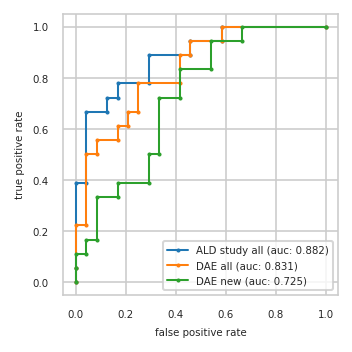

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.389   0.000 0.222   0.000 0.111
3          0.042 0.389   0.042 0.222   0.042 0.111
4          0.042 0.667   0.042 0.500   0.042 0.167
5          0.125 0.667   0.083 0.500   0.083 0.167
6          0.125 0.722   0.083 0.556   0.083 0.333
7          0.167 0.722   0.167 0.556   0.167 0.333
8          0.167 0.778   0.167 0.611   0.167 0.389
9          0.292 0.778   0.208 0.611   0.292 0.389
10         0.292 0.889   0.208 0.667   0.292 0.500
11         0.458 0.889   0.250 0.667   0.333 0.500
12         0.458 0.944   0.250 0.778   0.333 0.722
13         0.583 0.944   0.417 0.778   0.417 0.722
14         0.583 1.000   0.417 0.889   0.417 0.833
15         1.000 1.000   0.458 0.889   0.542 0.833
16           NaN   NaN   0.458 0.944   0.542 0.944
17           NaN   NaN   0.583 0.944   0.667 0.944
18           NaN   NaN   0.583 1.000   0.667 1.000
19           NaN   NaN   1.000 1.000   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,H3BLU2,P48163,Q9UI40;Q9UI40-2
2,P02766,C9JIZ6;P07602;P07602-2;P07602-3,B1AJQ6;Q86Y82
3,Q6UX72,Q9Y2T3;Q9Y2T3-3,P31321
4,P04075,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P61981,P04075,P51688
6,P14174,P14174,E5RJY1;E7ESM1;Q92597;Q92597-2;Q92597-3
7,Q9Y2T3;Q9Y2T3-3,Q14894,Q9H741
8,P05413;S4R371,P63104,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


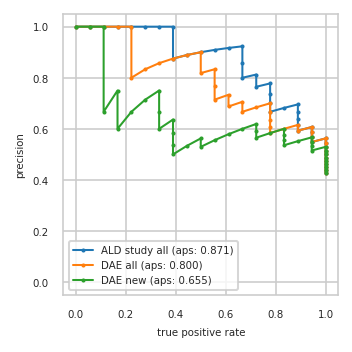

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.548 0.944     0.548 0.944     0.548 0.944
12         0.567 0.944     0.567 0.944     0.567 0.944
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.600 0.833     0.600 0.833
18         0.667 0.889     0.583 0.778     0.583 0.778
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.682 0.833     0.636 0.778     0.591 0.722
21         0.667 0.778     0.667 0.778     0.619 0.722
22         0.700 0.778     0.700 0.778     0.600 0.667
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.812 0.722     0.688 0.611     0.562 0.500
27         0.800 0.667     0.733 0.611     0.533 0.444
28         0.857 0.667     0.714 0.556     0.500 0.389
29         0.923 0.667     0.769 0.556     0.538 0.389
30         0.917 0.611     0.833 0.556     0.583 0.389
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


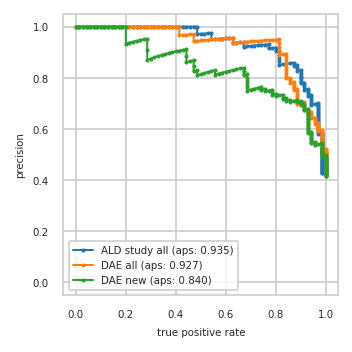

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


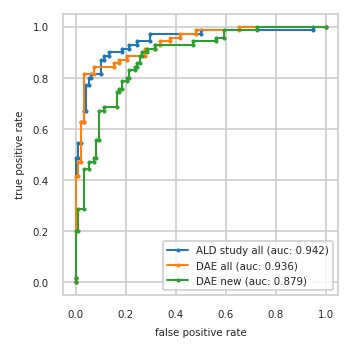

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}